In [73]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [74]:
# load the regional / industry data
file_path = 'regionalgrossvalueaddedbalancedbyindustryandallinternationalterritoriallevelsitlregions.xlsx'

df = pd.read_excel(file_path, sheet_name='Table 1b', header=1)

# Make sure "Region name" exists and extract the unique value of this column
if 'Region name' in df.columns:
    unique_regions = df['Region name'].dropna().unique()
    print("Region name:")
    for region in unique_regions:
        print(region)
else:
    print("The 'Region name' not found")


Region name:
United Kingdom
England
North East
North West
Yorkshire and The Humber
East Midlands
West Midlands
East
London
South East
South West
Wales
Scotland
Northern Ireland
Extra-Regio
United Kingdom less Extra-Regio


In [75]:
# load the pollution data
data_dir = "Dataset_v4"

# pnec value
target_substances = {
    "Copper": 1.0,
    "Cypermethrin":0.000013,
    "Benzo(a)pyrene": 0.00017,
    "Fluoranthene": 0.000762,
    "Indeno(1,2,3-cd)pyrene": 0.00017
}

# Used for storing all annual data
all_years_data = []

# Traverse from 2016 to 2023
for year in range(2016, 2024):
    file_name = f"d{str(year)[-2:]}_v4.csv"
    file_path = os.path.join(data_dir, file_name)

    try:
        df = pd.read_csv(file_path)
        df_filtered = df[df["SUBSTANCE NAME"].isin(target_substances.keys())].copy()
        df_filtered["Year"] = year
        df_filtered["PNEC"] = df_filtered["SUBSTANCE NAME"].map(target_substances)
        df_filtered["Pollution Score"] = df_filtered["QUANTITY RELEASED (kg)"] / df_filtered["PNEC"]

        # Summarize by REGION and SUBSTANCE
        df_grouped = (
            df_filtered.groupby(["Year", "REGION", "SUBSTANCE NAME"])
            .agg({"QUANTITY RELEASED (kg)": "sum", "Pollution Score": "sum"})
            .reset_index()
        )

        all_years_data.append(df_grouped)

    except FileNotFoundError:
        print(f"{file_path} not found")

# merge all years' data
final_df = pd.concat(all_years_data, ignore_index=True)

# Add to the pollution severity ranking
final_df["Rank"] = final_df.groupby(["Year", "SUBSTANCE NAME"])["Pollution Score"]\
                           .rank(method="dense", ascending=False)

# export as csv
final_df.to_csv("pollution_severity_ranked_by_region.csv", index=False)

# output few lines 
print(final_df.head(20))


    Year           REGION          SUBSTANCE NAME  QUANTITY RELEASED (kg)  \
0   2016    East Midlands          Benzo(a)pyrene                  5.9000   
1   2016    East Midlands                  Copper               3550.4800   
2   2016    East Midlands            Cypermethrin                  0.0000   
3   2016    East Midlands            Fluoranthene                  1.6900   
4   2016    East Midlands  Indeno(1,2,3-cd)pyrene                  8.9300   
5   2016  East of England          Benzo(a)pyrene                  4.3200   
6   2016  East of England                  Copper               5500.0000   
7   2016  East of England            Cypermethrin                  0.0000   
8   2016  East of England            Fluoranthene                  1.9700   
9   2016  East of England  Indeno(1,2,3-cd)pyrene                  7.8200   
10  2016           London          Benzo(a)pyrene                 39.6700   
11  2016           London                  Copper              16878.7160   

In [76]:
import pandas as pd
from scipy.stats import pearsonr

# Industrial data
df_income = pd.read_excel(
    "regionalgrossvalueaddedbalancedbyindustryandallinternationalterritoriallevelsitlregions.xlsx",
    sheet_name="Table 1b",
    header=1
)

# Selecte regions
target_regions = [
    "North East", "North West", "Yorkshire and The Humber",
    "East Midlands", "West Midlands", "East",
    "London", "South East", "South West"
]
df_income = df_income[df_income["Region name"].isin(target_regions)]

# Years
years = [str(y) for y in range(2015, 2024)]
df_income_long = df_income.melt(
    id_vars=["Region name", "SIC07 description"],
    value_vars=years,
    var_name="Year",
    value_name="Income"
)
df_income_long.rename(columns={"Region name": "REGION"}, inplace=True)
df_income_long["Year"] = df_income_long["Year"].astype(int)

# substance and PNEC
target_substances = {
    "Copper": 1.0,
    "Cypermethrin": 0.000013,
    "Benzo(a)pyrene": 0.00017,
    "Fluoranthene": 0.000762,
    "Indeno(1,2,3-cd)pyrene": 0.00017
}

# Continuously calculate the industry correlations of each substance
all_corrs = []

for substance, pnec in target_substances.items():
    df_sub = final_df[final_df["SUBSTANCE NAME"] == substance][["REGION", "Year", "Pollution Score"]].copy()
    df_sub["Severity"] = df_sub["Pollution Score"] / pnec

    df_sub_agg = df_sub.groupby(["REGION", "Year"])["Severity"].sum().reset_index()

    df_merge = pd.merge(df_income_long, df_sub_agg, on=["REGION", "Year"], how="inner")

    for industry, group in df_merge.groupby("SIC07 description"):
        if group["Income"].notna().sum() > 5:
            r, p = pearsonr(group["Income"], group["Severity"])
            all_corrs.append({
                "Industry": industry,
                "Pearson_r": r,
                "p_value": p,
                "Substance": substance
            })

df_corr_all = pd.DataFrame(all_corrs)

# Each industry × each substance
df_corr_pivot = df_corr_all.pivot(index="Industry", columns="Substance", values="Pearson_r")

# Sort the average absolute correlation coefficients
df_corr_pivot["Mean_abs_r"] = df_corr_pivot.abs().mean(axis=1)
df_corr_top10 = df_corr_pivot.sort_values(by="Mean_abs_r", ascending=False).head(10)

# Results
print("=== Correlation between Industial × Substance （Top10） ===")
print(df_corr_top10)


=== Correlation between Industial × Substance （Top10） ===
Substance                                          Benzo(a)pyrene  Copper  \
Industry                                                                    
Security and investigation activities                      0.6797  0.9005   
Arts, entertainment and recreation                         0.6379  0.9127   
Professional, scientific and technical activities          0.6177  0.9132   
Services sector                                            0.6326  0.8967   
Employment activities                                      0.6565  0.9098   
Administrative and support service activities              0.6321  0.8782   
All industries                                             0.6349  0.8810   
Travel agency and tour operator activities                 0.6498  0.8446   
Creative, arts and entertainment activities                0.5812  0.9066   
Real estate activities, excluding imputed rental           0.6159  0.9145   

Substance        

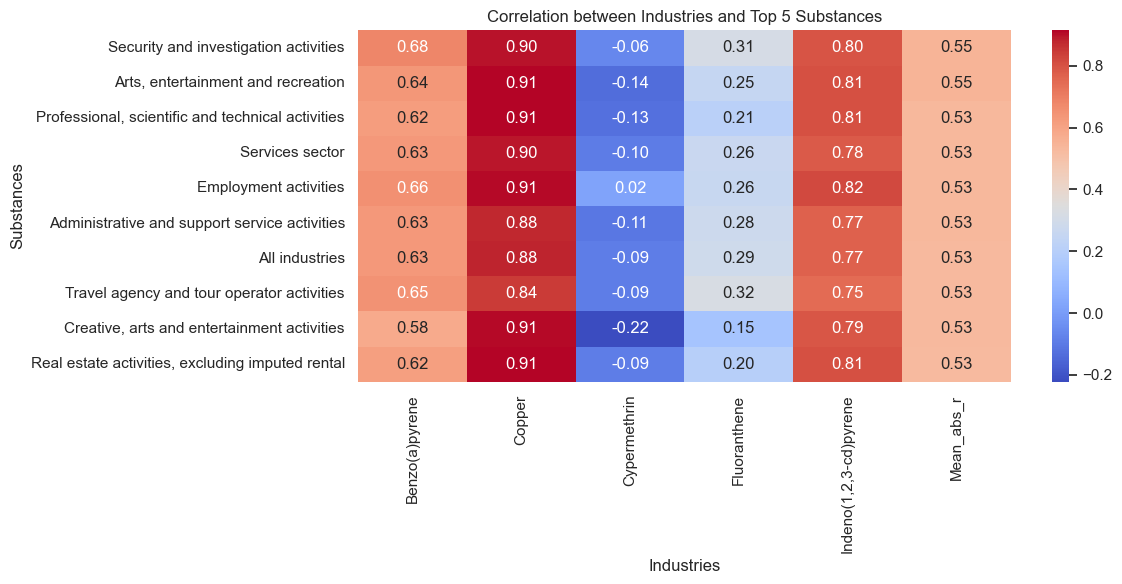

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(df_corr_top10, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Industries and Top 5 Substances")
plt.xlabel("Industries")
plt.ylabel("Substances")
plt.tight_layout()
plt.show()


### Correlation analysis

Combined data: r = 0.1298, p = 0.0000


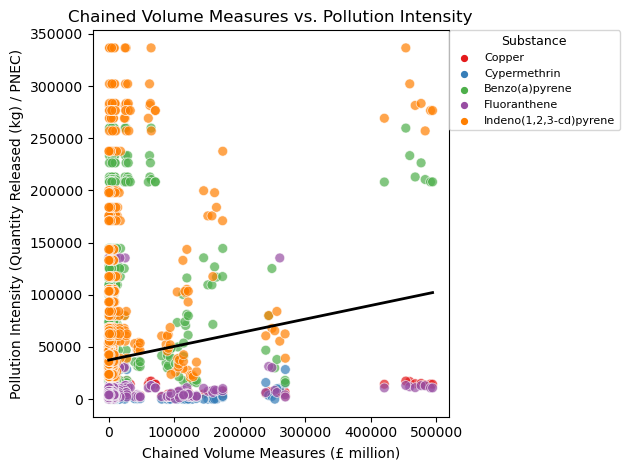

In [77]:
indu_df = df_regi_indu[
    (df_regi_indu["SIC07 description"].isin(target_industries)) &
    (df_regi_indu["Region name"].isin(target_regions))
]

years = [str(y) for y in range(2015, 2024)]
indu_df = indu_df[["Region name"] + years]

indu_long = indu_df.melt(
    id_vars="Region name",
    var_name="Year",
    value_name="Indu_Income"
)
indu_long.columns = ["REGION", "Year", "Indu_Income"]
indu_long["Year"] = indu_long["Year"].astype(int)
indu_long["REGION"] = indu_long["REGION"].str.lower()

# pollution data
pollution_df = final_df[["Year", "REGION", "SUBSTANCE NAME", "QUANTITY RELEASED (kg)"]].copy()
pollution_df["Year"] = pollution_df["Year"].astype(int)
pollution_df["REGION"] = pollution_df["REGION"].str.strip().str.lower()

#Continuously process the five substances and combine them
all_data = []

for substance, pnec in target_substances.items():
    sub_df = pollution_df[pollution_df["SUBSTANCE NAME"] == substance].copy()
    sub_df["Pollution Intensity"] = sub_df["QUANTITY RELEASED (kg)"] / pnec
    
    sub_sum = sub_df.groupby(["REGION", "Year"])["Pollution Intensity"].sum().reset_index()
    merged = pd.merge(sub_sum, indu_long, on=["REGION", "Year"], how="inner").dropna()
    merged["Substance"] = substance
    all_data.append(merged)

merged_all = pd.concat(all_data, ignore_index=True)

# Remove extreme values (IQR method, for Pollution Intensity)
Q1 = merged_all["Pollution Intensity"].quantile(0.05)
Q3 = merged_all["Pollution Intensity"].quantile(0.95)
IQR = Q3 - Q1
lower_bound = Q1 - 0.5 * IQR
upper_bound = Q3 + 0.5 * IQR
merged_all = merged_all[(merged_all["Pollution Intensity"] >= lower_bound) &
                        (merged_all["Pollution Intensity"] <= upper_bound)]

# Different substances have different colors, 
# but there is only one comprehensive regression line
sns.scatterplot(
    x="Indu_Income", 
    y="Pollution Intensity", 
    hue="Substance",
    data=merged_all,
    palette="Set1",
    s=50,
    alpha=0.7
)

# A single regression line (based on all substance data)
sns.regplot(
    x="Indu_Income",
    y="Pollution Intensity",
    data=merged_all,
    scatter=False,
    ci=None,
    color="black",
    line_kws={"linewidth": 2}
)


# Pearson Correlation coefficient (combined data)
r, p = pearsonr(merged_all["Indu_Income"], merged_all["Pollution Intensity"])
print(f"Combined data: r = {r:.4f}, p = {p:.4f}")

plt.title("Chained Volume Measures vs. Pollution Intensity")
plt.xlabel("Chained Volume Measures (£ million)")
plt.ylabel("Pollution Intensity (Quantity Released (kg) / PNEC)")

# Legend
plt.legend(
    title="Substance",
    bbox_to_anchor=(1, 1),  
    borderaxespad=0,
    markerscale=0.7,  
    fontsize=8,      
    title_fontsize=9  
)


plt.tight_layout()
plt.show()


### Regression

In [78]:
import statsmodels.api as sm

X = merged_all["Indu_Income"]

y = merged_all["Pollution Intensity"]

# constant
X_const = sm.add_constant(X)
# OLS regression
model = sm.OLS(y, X_const).fit()

print(model.summary())

# coeff
intercept = model.params["const"]
slope = model.params["Indu_Income"]

# print the equation
print("\nRegression Equation：")
print(f"Pollution Intensity = {intercept:.6f} + {slope:.6f} * Chained Volume Measures")

# Print the goodness of fit
print(f"\nR-squared: {model.rsquared:.4f}")
print(f"Adjusted R-squared: {model.rsquared_adj:.4f}")


                             OLS Regression Results                            
Dep. Variable:     Pollution Intensity   R-squared:                       0.017
Model:                             OLS   Adj. R-squared:                  0.016
Method:                  Least Squares   F-statistic:                     46.54
Date:                 Sat, 16 Aug 2025   Prob (F-statistic):           1.10e-11
Time:                         12:31:11   Log-Likelihood:                -33963.
No. Observations:                 2718   AIC:                         6.793e+04
Df Residuals:                     2716   BIC:                         6.794e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3.745e+04   1317.073     28

Regional-level regression:
  Pearson r = 0.0838
  p-value   = 8.4362e-01
  Significant? No
  Regression equation: Pollution_Intensity = 25256298.2401 + 0.3197 * Indu_Income
                             OLS Regression Results                            
Dep. Variable:     Pollution_Intensity   R-squared:                       0.007
Model:                             OLS   Adj. R-squared:                 -0.158
Method:                  Least Squares   F-statistic:                   0.04243
Date:                 Sat, 16 Aug 2025   Prob (F-statistic):              0.844
Time:                         12:40:13   Log-Likelihood:                -150.52
No. Observations:                    8   AIC:                             305.0
Df Residuals:                        6   BIC:                             305.2
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                  coef    s

/Users/macbookair/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


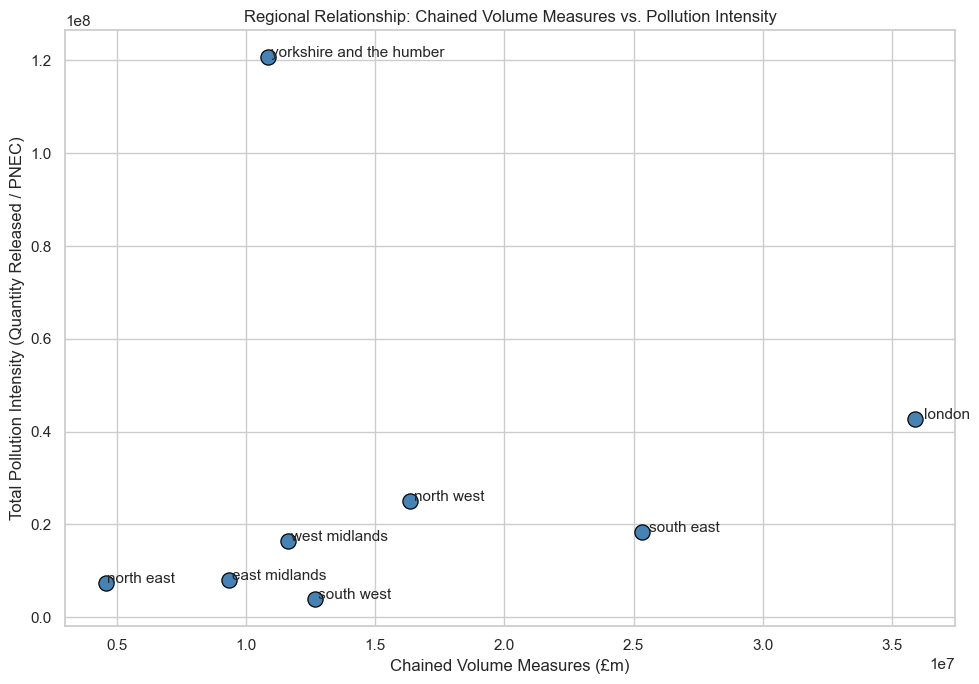

In [88]:
import statsmodels.api as sm
from scipy.stats import pearsonr

# calculate the regional level Pollution Intensity
merged_df["Pollution_Intensity"] = merged_df["QUANTITY RELEASED (kg)"] / merged_df["PNEC"]

# Aggregate by REGION
region_summary = merged_df.groupby("REGION").agg({
    "Pollution_Intensity": "sum",
    "Indu_Income": "sum"
}).reset_index()


# statistic analysis

x = region_summary["Indu_Income"]
y = region_summary["Pollution_Intensity"]

# Pearson Correlation
r, p_value = pearsonr(x, y)

# OLS regression
X_const = sm.add_constant(x)
model = sm.OLS(y, X_const).fit()


print("Regional-level regression:")
print(f"  Pearson r = {r:.4f}")
print(f"  p-value   = {p_value:.4e}")
print(f"  Significant? {'Yes' if p_value < 0.05 else 'No'}")
print("  Regression equation: Pollution_Intensity = "
      f"{model.params['const']:.4f} + {model.params['Indu_Income']:.4f} * Indu_Income")
print(model.summary())

# ---------------------------
# 可视化 (无拟合线)
# ---------------------------
plt.figure(figsize=(10, 7))
sns.set(style="whitegrid")

sns.scatterplot(
    data=region_summary,
    x="Indu_Income",
    y="Pollution_Intensity",
    s=120,
    color="steelblue",
    edgecolor="black"
)

# Mark the name of the region
for i, row in region_summary.iterrows():
    plt.text(
        row["Indu_Income"] * 1.01,
        row["Pollution_Intensity"],
        row["REGION"],
        fontsize=11
    )

plt.xlabel("Chained Volume Measures (£m)")
plt.ylabel("Total Pollution Intensity (Quantity Released / PNEC)")
plt.title("Regional Relationship: Chained Volume Measures vs. Pollution Intensity")
plt.tight_layout()
plt.show()


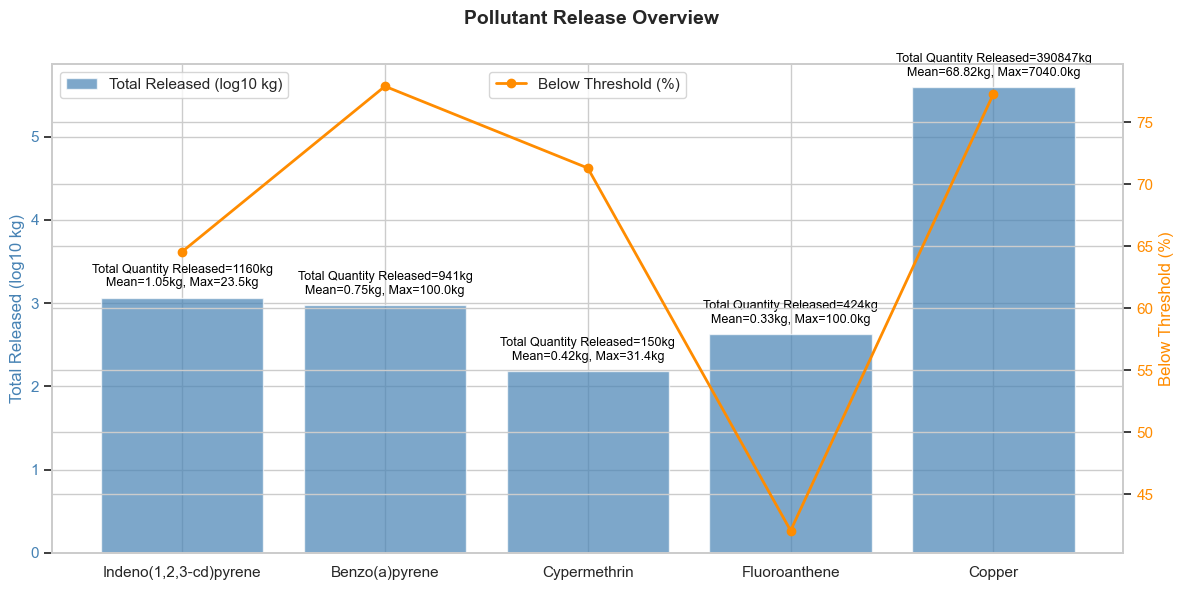

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load the data
data = {
    "Pollutant": ["Indeno(1,2,3-cd)pyrene", "Benzo(a)pyrene", "Cypermethrin", "Fluoroanthene", "Copper"],
    "Total Quantity Released (kg)": [1160.19, 941.03, 149.8, 424.2, 390846.92],
    "Mean": [1.05, 0.75, 0.42, 0.33, 68.82],
    "Max": [23.5, 100, 31.35, 100, 7040],
    "Percentage < Threshold": [64.56, 77.91, 71.31, 42.05, 77.3]
}
df = pd.DataFrame(data)

# Total log10 conversion (for plotting)
df["Total_log"] = np.log10(df["Total Quantity Released (kg)"] + 1)


fig, ax1 = plt.subplots(figsize=(12,6))

# Bar chart: Total Emissions (log scale)
bars = ax1.bar(df["Pollutant"], df["Total_log"], color="steelblue", alpha=0.7, label="Total Released (log10 kg)")
ax1.set_ylabel("Total Released (log10 kg)", color="steelblue")
ax1.tick_params(axis="y", labelcolor="steelblue")

# The second Y-axis: proportion below the threshold
ax2 = ax1.twinx()
ax2.plot(df["Pollutant"], df["Percentage < Threshold"], color="darkorange", marker="o", linewidth=2, label="Below Threshold (%)")
ax2.set_ylabel("Below Threshold (%)", color="darkorange")
ax2.tick_params(axis="y", labelcolor="darkorange")

# Mark "Mean", "Max" and "Total" (true values) at the top of the column
for i, (mean, maxv, total, bar) in enumerate(zip(df["Mean"], df["Max"], df["Total Quantity Released (kg)"], bars)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 0.1,
             f"Total Quantity Released={total:.0f}kg\nMean={mean:.2f}kg, Max={maxv:.1f}kg",
             ha="center", va="bottom", fontsize=9, color="black")


fig.suptitle("Pollutant Release Overview", fontsize=14, fontweight="bold")
ax1.legend(loc="upper left")
ax2.legend(loc="upper center")

plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


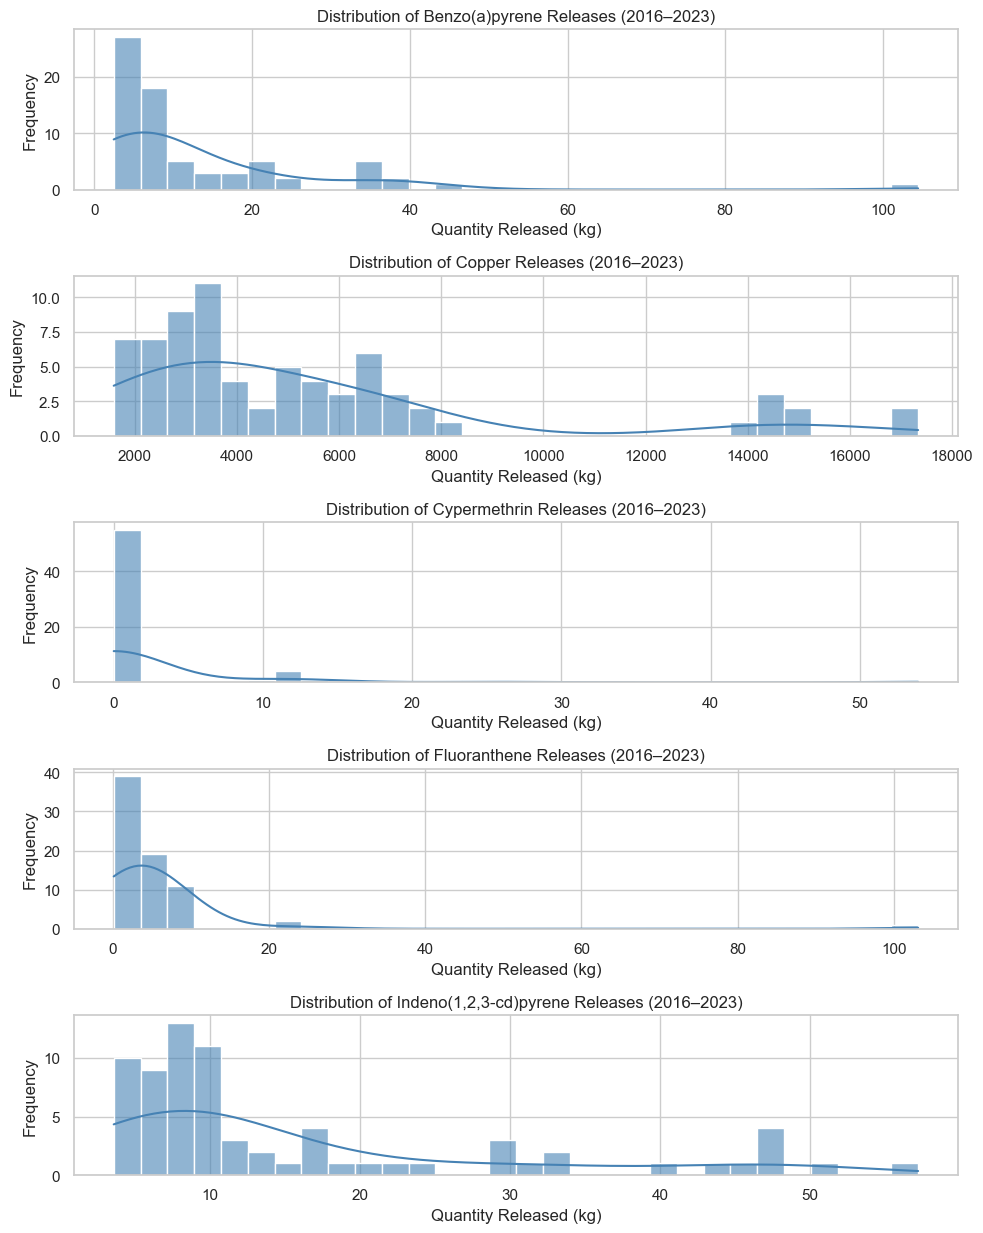

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Get the names of all pollutants
pollutants = final_df["SUBSTANCE NAME"].unique()

# distribution plot
fig, axes = plt.subplots(len(pollutants), 1, figsize=(10, 2.5*len(pollutants)))
if len(pollutants) == 1:
    axes = [axes]  # Compatible with the situation of a single pollutant

for ax, pollutant in zip(axes, pollutants):
    subset = final_df[final_df["SUBSTANCE NAME"] == pollutant]

    # Draw a distribution graph (Histogram KDE)
    sns.histplot(subset["QUANTITY RELEASED (kg)"], bins=30, kde=True, ax=ax, color="steelblue", alpha=0.6)
    
    ax.set_title(f"Distribution of {pollutant} Releases (2016–2023)")
    ax.set_xlabel("Quantity Released (kg)")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()


In [104]:
import pandas as pd
from scipy.stats import pearsonr

# Industrial data
df_income = pd.read_excel(
    "regionalgrossvalueaddedbalancedbyindustryandallinternationalterritoriallevelsitlregions.xlsx",
    sheet_name="Table 1b",
    header=1
)

# Select regions
target_regions = [
    "North East", "North West", "Yorkshire and The Humber",
    "East Midlands", "West Midlands", "East",
    "London", "South East", "South West"
]
df_income = df_income[df_income["Region name"].isin(target_regions)]

# Years
years = [str(y) for y in range(2015, 2024)]
df_income_long = df_income.melt(
    id_vars=["Region name", "SIC07 description"],
    value_vars=years,
    var_name="Year",
    value_name="Income"
)
df_income_long.rename(columns={"Region name": "REGION"}, inplace=True)
df_income_long["Year"] = df_income_long["Year"].astype(int)

# filter industries that only contain 'manufacture', but exclude 'Manufacturing'.
df_income_long = df_income_long[
    (df_income_long["SIC07 description"].str.contains("manufacture", case=False, na=False)) &
    (df_income_long["SIC07 description"].str.strip().str.lower() != "manufacturing")
]

# Substances and PNEC
target_substances = {
    "Copper": 1.0,
    "Cypermethrin": 0.000013,
    "Benzo(a)pyrene": 0.00017,
    "Fluoranthene": 0.000762,
    "Indeno(1,2,3-cd)pyrene": 0.00017
}

# Continuously calculate the industry correlations of each substance
all_corrs = []

for substance, pnec in target_substances.items():
    df_sub = final_df[final_df["SUBSTANCE NAME"] == substance][["REGION", "Year", "Pollution Score"]].copy()
    df_sub["Severity"] = df_sub["Pollution Score"] / pnec

    df_sub_agg = df_sub.groupby(["REGION", "Year"])["Severity"].sum().reset_index()

    df_merge = pd.merge(df_income_long, df_sub_agg, on=["REGION", "Year"], how="inner")

    for industry, group in df_merge.groupby("SIC07 description"):
        if group["Income"].notna().sum() > 5:
            r, p = pearsonr(group["Income"], group["Severity"])
            all_corrs.append({
                "Industry": industry,
                "Pearson_r": r,
                "p_value": p,
                "Substance": substance
            })

df_corr_all = pd.DataFrame(all_corrs)

# Each industry × each substance
df_corr_pivot = df_corr_all.pivot(index="Industry", columns="Substance", values="Pearson_r")

# Sort the average absolute correlation coefficients
df_corr_pivot["Mean_abs_r"] = df_corr_pivot.abs().mean(axis=1)
df_corr_top10 = df_corr_pivot.sort_values(by="Mean_abs_r", ascending=False).head(10)

# Results
print("=== Correlation between Industrial × Substance （Top10, only manufacture industries） ===")
print(df_corr_top10)


=== Correlation between Industrial × Substance （Top10, only manufacture industries） ===
Substance                                           Benzo(a)pyrene  Copper  \
Industry                                                                     
Manufacture of beverages and tobacco products               0.4464  0.5032   
Manufacture of furniture                                   -0.1837 -0.3893   
Manufacture of wood products, except furniture             -0.2190 -0.4851   
Manufacture of machinery and equipment                     -0.3128 -0.5013   
Manufacture of other non-metallic mineral products         -0.2511 -0.4615   
Manufacture of wearing apparel                              0.2802  0.4798   
Manufacture of electrical equipment                        -0.1140 -0.3602   
Manufacture of rubber, plastic and non-metallic...         -0.1869 -0.4229   
Manufacture of fabricated metal products                   -0.1097 -0.3284   
Manufacture of basic and fabricated metal products    

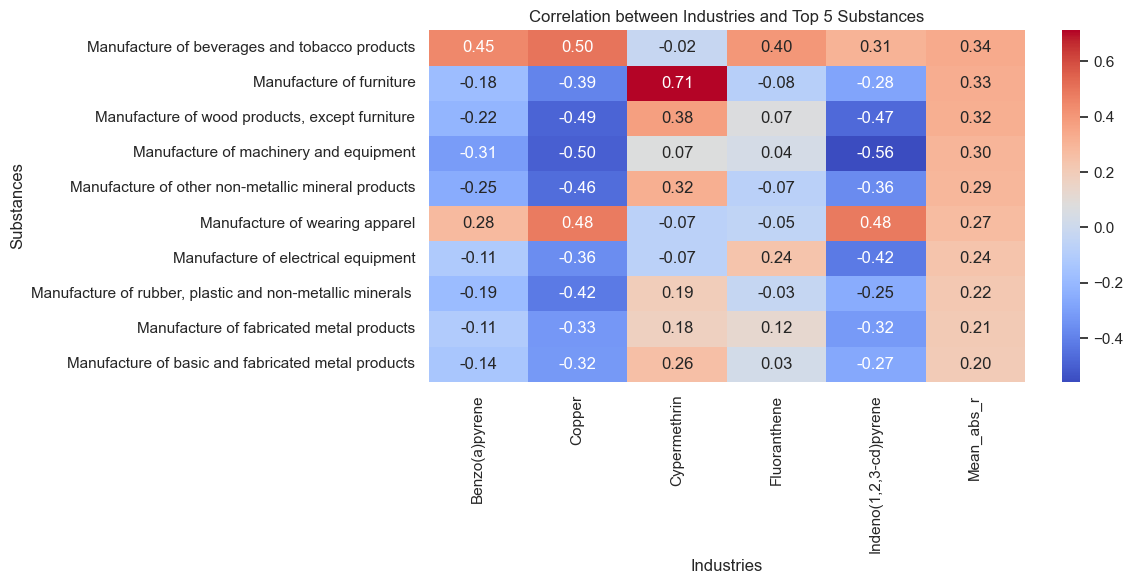

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(df_corr_top10, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Industries and Top 5 Substances")
plt.xlabel("Industries")
plt.ylabel("Substances")
plt.tight_layout()
plt.show()


Combined data (after outlier removal): r = 0.0682, p = 0.0007


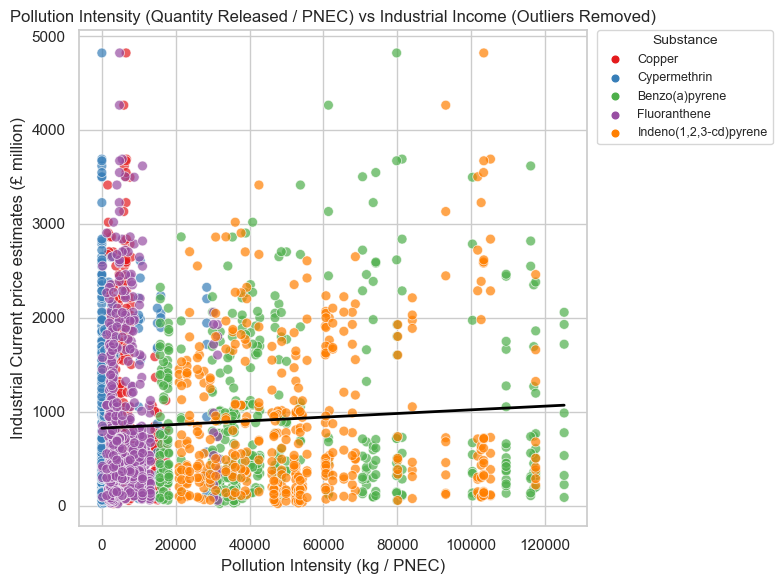

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

target_substances = {
    "Copper": 1.0,
    "Cypermethrin": 0.000013,
    "Benzo(a)pyrene": 0.00017,
    "Fluoranthene": 0.000762,
    "Indeno(1,2,3-cd)pyrene": 0.00017
}

# industial data
df_regi_indu = pd.read_excel(
    "regionalgrossvalueaddedbalancedbyindustryandallinternationalterritoriallevelsitlregions.xlsx",
    sheet_name="Table 1c",
    header=1
)

target_regions = [
    "North East", "North West", "Yorkshire and The Humber",
    "East Midlands", "West Midlands", "East",
    "London", "South East", "South West"
]

target_industries = [
    'Manufacture of beverages and tobacco products',          
    'Manufacture of furniture',                                
    'Manufacture of wood products, except furniture',          
    'Manufacture of machinery and equipment',                 
    'Manufacture of other non-metallic mineral products',      
    'Manufacture of wearing apparel',                         
    'Manufacture of electrical equipment',                       
    'Manufacture of rubber, plastic and non-metallic minerals',        
    'Manufacture of fabricated metal products',                  
    'Manufacture of basic and fabricated metal products'
]

indu_df = df_regi_indu[
    (df_regi_indu["SIC07 description"].isin(target_industries)) &
    (df_regi_indu["Region name"].isin(target_regions))
]

years = [str(y) for y in range(2015, 2024)]
indu_df = indu_df[["Region name"] + years]

indu_long = indu_df.melt(
    id_vars="Region name",
    var_name="Year",
    value_name="Indu_Income"
)
indu_long.columns = ["REGION", "Year", "Indu_Income"]
indu_long["Year"] = indu_long["Year"].astype(int)
indu_long["REGION"] = indu_long["REGION"].str.lower()

# Pollution data
pollution_df = final_df[["Year", "REGION", "SUBSTANCE NAME", "QUANTITY RELEASED (kg)"]].copy()
pollution_df["Year"] = pollution_df["Year"].astype(int)
pollution_df["REGION"] = pollution_df["REGION"].str.strip().str.lower()

# Recycle and process five substances and combine them
all_data = []

for substance, pnec in target_substances.items():
    sub_df = pollution_df[pollution_df["SUBSTANCE NAME"] == substance].copy()
    sub_df["Pollution Intensity"] = sub_df["QUANTITY RELEASED (kg)"] / pnec
    
    sub_sum = sub_df.groupby(["REGION", "Year"])["Pollution Intensity"].sum().reset_index()
    merged = pd.merge(sub_sum, indu_long, on=["REGION", "Year"], how="inner").dropna()
    merged["Substance"] = substance
    all_data.append(merged)

merged_all = pd.concat(all_data, ignore_index=True)

# Remove extreme values (IQR method, for Pollution Intensity)
Q1 = merged_all["Pollution Intensity"].quantile(0.25)
Q3 = merged_all["Pollution Intensity"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
merged_all = merged_all[(merged_all["Pollution Intensity"] >= lower_bound) &
                        (merged_all["Pollution Intensity"] <= upper_bound)]

# plotting
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="Pollution Intensity",
    y="Indu_Income",
    hue="Substance",
    data=merged_all,
    palette="Set1",
    s=50,
    alpha=0.7
)

# Single tropic of cancer (the combination of all substances)
sns.regplot(
    x="Pollution Intensity",
    y="Indu_Income",
    data=merged_all,
    scatter=False,
    ci=None,
    color="black",
    line_kws={"linewidth": 2}
)

# Pearson Correlation Coefficient
r, p = pearsonr(merged_all["Pollution Intensity"], merged_all["Indu_Income"])
print(f"Combined data (after outlier removal): r = {r:.4f}, p = {p:.4f}")

plt.title("Pollution Intensity (Quantity Released / PNEC) vs Industrial Income (Outliers Removed)")
plt.xlabel("Pollution Intensity (kg / PNEC)")
plt.ylabel("Industrial Current price estimates (£ million)")



plt.legend(
    title="Substance",
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0,
    markerscale=0.8,   
    fontsize=9,        
    title_fontsize=10  
)

plt.tight_layout()
plt.show()


In [110]:
import statsmodels.api as sm

X = merged_all["Indu_Income"]

y = merged_all["Pollution Intensity"]

# constant
X_const = sm.add_constant(X)
# OLS regression
model = sm.OLS(y, X_const).fit()

print(model.summary())

# coeff
intercept = model.params["const"]
slope = model.params["Indu_Income"]

# print the equation
print("\nRegression Equation：")
print(f"Pollution Intensity = {intercept:.6f} + {slope:.6f} * Chained Volume Measures")

# Print the goodness of fit
print(f"\nR-squared: {model.rsquared:.4f}")
print(f"Adjusted R-squared: {model.rsquared_adj:.4f}")


                             OLS Regression Results                            
Dep. Variable:     Pollution Intensity   R-squared:                       0.005
Model:                             OLS   Adj. R-squared:                  0.004
Method:                  Least Squares   F-statistic:                     11.46
Date:                 Sat, 23 Aug 2025   Prob (F-statistic):           0.000722
Time:                         20:54:15   Log-Likelihood:                -28708.
No. Observations:                 2457   AIC:                         5.742e+04
Df Residuals:                     2455   BIC:                         5.743e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.995e+04    841.661     23

### The most related industrials with each susbtance

In [115]:
import pandas as pd
from scipy.stats import pearsonr

# Industrial data
df_income = pd.read_excel(
    "regionalgrossvalueaddedbalancedbyindustryandallinternationalterritoriallevelsitlregions.xlsx",
    sheet_name="Table 1b",
    header=1
)

# Select regions
target_regions = [
    "North East", "North West", "Yorkshire and The Humber",
    "East Midlands", "West Midlands", "East",
    "London", "South East", "South West"
]
df_income = df_income[df_income["Region name"].isin(target_regions)]

# Years
years = [str(y) for y in range(2015, 2024)]
df_income_long = df_income.melt(
    id_vars=["Region name", "SIC07 description"],
    value_vars=years,
    var_name="Year",
    value_name="Income"
)
df_income_long.rename(columns={"Region name": "REGION"}, inplace=True)
df_income_long["Year"] = df_income_long["Year"].astype(int)

# only retain specific sub-sectors of Manufacturing, excluding the general category "Manufacturing"
df_income_long = df_income_long[
    (df_income_long["SIC07 description"].str.contains("manufacture", case=False, na=False)) &
    (df_income_long["SIC07 description"].str.strip().str.lower() != "manufacturing")
]

# Substances and PNEC
target_substances = {
    "Copper": 1.0,
    "Cypermethrin": 0.000013,
    "Benzo(a)pyrene": 0.00017,
    "Fluoranthene": 0.000762,
    "Indeno(1,2,3-cd)pyrene": 0.00017
}

# Save the result of each substance
substance_top10 = {}

with pd.ExcelWriter("Industry_Substance_Top10_Positive.xlsx") as writer:
    for substance, pnec in target_substances.items():
        all_corrs = []
        df_sub = final_df[final_df["SUBSTANCE NAME"] == substance][["REGION", "Year", "Pollution Score"]].copy()
        df_sub["Severity"] = df_sub["Pollution Score"] / pnec

        df_sub_agg = df_sub.groupby(["REGION", "Year"])["Severity"].sum().reset_index()

        df_merge = pd.merge(df_income_long, df_sub_agg, on=["REGION", "Year"], how="inner")

        for industry, group in df_merge.groupby("SIC07 description"):
            if group["Income"].notna().sum() > 5:
                r, p = pearsonr(group["Income"], group["Severity"])
                if r > 0:  # Only retain the positive correlation
                    all_corrs.append({
                        "Industry": industry,
                        "Pearson_r": r,
                        "p_value": p
                    })

        df_corr = pd.DataFrame(all_corrs)
        df_corr["abs_r"] = df_corr["Pearson_r"].abs()
        df_corr_top10 = df_corr.sort_values(by="abs_r", ascending=False).head(10)

        # save to dict
        substance_top10[substance] = df_corr_top10

        # write to Excel sheet
        df_corr_top10.to_excel(writer, sheet_name=substance, index=False)

print("✅ 正相关 Top10 correlated industries per substance 已保存到 Industry_Substance_Top10_Positive.xlsx")


✅ 正相关 Top10 correlated industries per substance 已保存到 Industry_Substance_Top10_Positive.xlsx



=== Copper ===


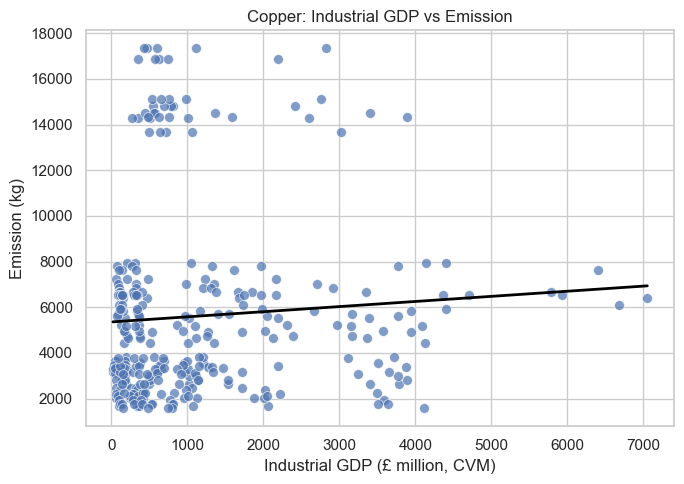


=== Cypermethrin ===


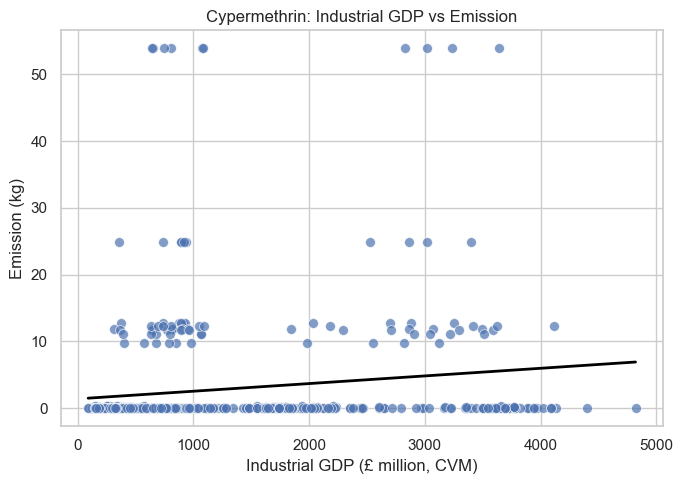


=== Benzo(a)pyrene ===


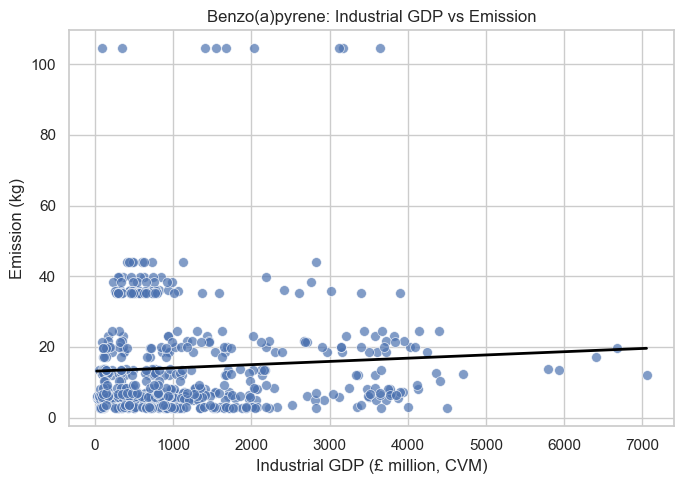


=== Fluoranthene ===


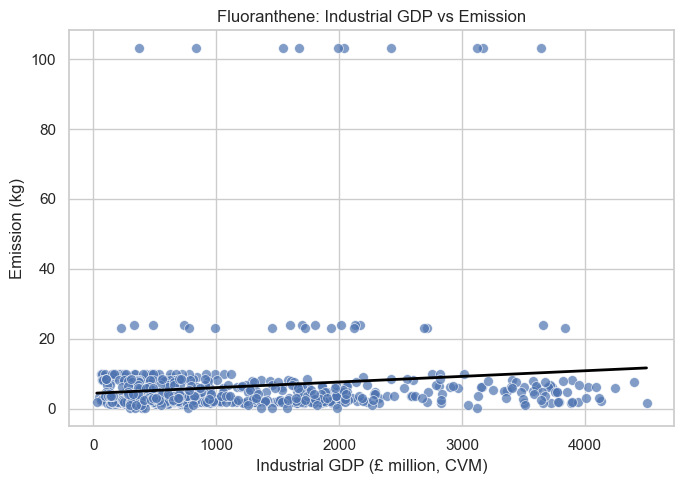


=== Indeno(1,2,3-cd)pyrene ===


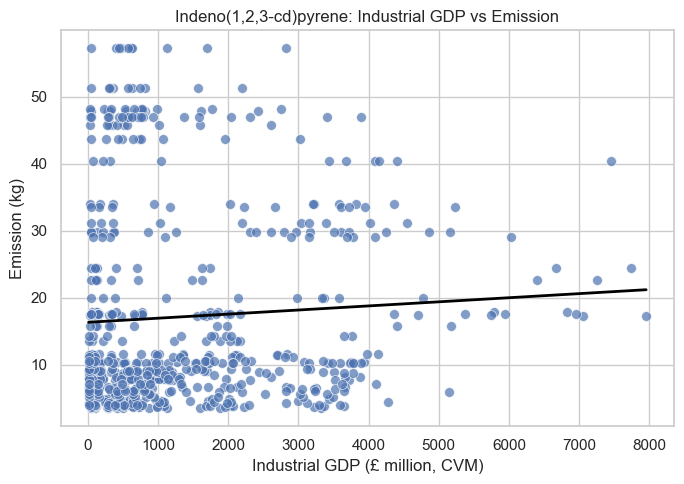

In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

df_regi_indu = pd.read_excel(
    "regionalgrossvalueaddedbalancedbyindustryandallinternationalterritoriallevelsitlregions.xlsx",
    sheet_name="Table 1c",
    header=1
)

target_regions = [
    "North East", "North West", "Yorkshire and The Humber",
    "East Midlands", "West Midlands", "East",
    "London", "South East", "South West"
]

years = [str(y) for y in range(2015, 2024)]

pollution_df = final_df[["Year", "REGION", "SUBSTANCE NAME", "QUANTITY RELEASED (kg)"]].copy()
pollution_df["Year"] = pollution_df["Year"].astype(int)
pollution_df["REGION"] = pollution_df["REGION"].str.strip().str.lower()

# Treat each substance separately
substance_industries = {
    "Copper": [
        'Manufacture of beverages and tobacco products',
        'Manufacture of wearing apparel',
        'Manufacture of food, beverages and tobacco',
        'Manufacture of textiles, wearing apparel and leather',
        'Manufacture of motor vehicles'
    ],
    "Cypermethrin": [
        'Manufacture of furniture',
        'Manufacture of wood products, except furniture',
        'Manufacture of textiles',
        'Manufacture of basic metals',
        'Manufacture of other non-metallic mineral products',
        'Manufacture of basic and fabricated metal products',
        'Manufacture of food products',
        'Manufacture of coke, refined petroleum and chemicals',
        'Manufacture of food, beverages and tobacco',
        'Manufacture of textiles, wearing apparel and leather'
    ],
    "Benzo(a)pyrene": [
        'Manufacture of beverages and tobacco products',
        'Manufacture of wearing apparel',
        'Manufacture of food, beverages and tobacco',
        'Manufacture of pharmaceutical products',
        'Manufacture of textiles, wearing apparel and leather',
        'Manufacture of computer, electronic and optical products',
        'Manufacture of wood and paper products and printing',
        'Manufacture of coke, refined petroleum and chemicals',
        'Manufacture of motor vehicles'
    ],
    "Fluoranthene": [
        'Manufacture of beverages and tobacco products',
        'Manufacture of computer, electronic and optical products',
        'Manufacture of pharmaceutical products',
        'Manufacture of wood and paper products and printing',
        'Manufacture of electrical equipment',
        'Manufacture of fabricated metal products',
        'Manufacture of food, beverages and tobacco',
        'Manufacture of coke, refined petroleum and chemicals',
        'Manufacture of wood products, except furniture',
        'Manufacture of machinery and equipment'
    ],
    "Indeno(1,2,3-cd)pyrene": [
        'Manufacture of wearing apparel',
        'Manufacture of beverages and tobacco products',
        'Manufacture of textiles, wearing apparel and leather',
        'Manufacture of food, beverages and tobacco',
        'Manufacture of motor vehicles',
        'Manufacture of leather products',
        'Manufacture of transport equipment',
        'Manufacture of pharmaceutical products',
        'Manufacture of coke, refined petroleum and chemicals',
        'Manufacture of food products'
    ]
}

# Store the regression results
detailed_results = []

for substance, industries in substance_industries.items():
    print(f"\n=== {substance} ===")
    
    # Select industry data
    indu_df = df_regi_indu[
        (df_regi_indu["SIC07 description"].isin(industries)) &
        (df_regi_indu["Region name"].isin(target_regions))
    ]
    
    indu_df = indu_df[["Region name"] + years]
    
    indu_long = indu_df.melt(
        id_vars="Region name",
        var_name="Year",
        value_name="Indu_Income"
    )
    indu_long.columns = ["REGION", "Year", "Indu_Income"]
    indu_long["Year"] = indu_long["Year"].astype(int)
    indu_long["REGION"] = indu_long["REGION"].str.lower()
    
    # pollution data
    sub_df = pollution_df[pollution_df["SUBSTANCE NAME"] == substance].copy()
    sub_sum = sub_df.groupby(["REGION", "Year"])["QUANTITY RELEASED (kg)"].sum().reset_index()
    
    # merge the data
    merged = pd.merge(sub_sum, indu_long, on=["REGION", "Year"], how="inner").dropna()
    

    if len(merged) > 2:
        # earson Correlation Coefficient
        r, p = pearsonr(merged["Indu_Income"], merged["QUANTITY RELEASED (kg)"])

        # linear regression (x=Indu_Income, y=Emission)
        X = merged[["Indu_Income"]].values
        y = merged["QUANTITY RELEASED (kg)"].values
        model = LinearRegression().fit(X, y)
        slope = model.coef_[0]
        intercept = model.intercept_

        detailed_results.append({
            "Substance": substance,
            "n": len(merged),
            "Pearson_r": round(r, 4),
            "p_value": round(p, 4),
            "Slope (β)": round(slope, 4),
            "Intercept (α)": round(intercept, 4),
            "Formula": f"Emission = {intercept:.2f} + {slope:.4f} * Industial GDP"
        })

    # plotting
    plt.figure(figsize=(7, 5))
    sns.scatterplot(
        x="Indu_Income",
        y="QUANTITY RELEASED (kg)",
        data=merged,
        s=50,
        alpha=0.7
    )
    
    sns.regplot(
        x="Indu_Income",
        y="QUANTITY RELEASED (kg)",
        data=merged,
        scatter=False,
        ci=None,
        color="black",
        line_kws={"linewidth": 2}
    )
    
    plt.title(f"{substance}: Industrial GDP vs Emission")
    plt.xlabel("Industrial GDP (£ million, CVM)")
    plt.ylabel("Emission (kg)")
    plt.tight_layout()
    plt.show()
    


In [135]:
# print the results
df_detailed = pd.DataFrame(detailed_results)
print("=== Regression Results with Formulas ===")
print(df_detailed)


=== Regression Results with Formulas ===
                Substance    n  Pearson_r  p_value  Slope (β)  Intercept (α)  \
0                  Copper  320     0.0737   0.1882     0.2242      5358.6516   
1            Cypermethrin  550     0.1513   0.0004     0.0011         1.3954   
2          Benzo(a)pyrene  576     0.0688   0.0991     0.0009        13.1571   
3            Fluoranthene  640     0.1287   0.0011     0.0016         4.4062   
4  Indeno(1,2,3-cd)pyrene  640     0.0618   0.1184     0.0006        16.3676   

                                       Formula  
0  Emission = 5358.65 + 0.2242 * Industial GDP  
1     Emission = 1.40 + 0.0011 * Industial GDP  
2    Emission = 13.16 + 0.0009 * Industial GDP  
3     Emission = 4.41 + 0.0016 * Industial GDP  
4    Emission = 16.37 + 0.0006 * Industial GDP  
